# Suggested Algorithm:
1) Choosing part of the data (sentences up to 20 words)

2) Perform word embedding using glove

3) Cluster all the words using dbscan

4) Change all words in the Dict to a "Centroid" 

5) Check if we get K=2 anonymity 

6) If not yet - remove words that reduces k (put in parantesis)

In [ ]:
# Imports
import sklearn
import pandas as pd
import numpy as np
import random
import re
from numpy.linalg import norm
from sklearn.model_selection import train_test_split
from itertools import islice
from sklearn.feature_extraction.text import CountVectorizer


### 1) Choosing part of the data (sentences up to 20 words)


In [ ]:
# Uploading the data
COLAB = True
first_run = True

In [ ]:
if COLAB:
    from google.colab import drive
    from os.path import exists

    amazon_train_file = 'train.ft.txt.bz2'

    if exists(amazon_train_file):
        train_file = amazon_train_file
    else:
        drive.mount('/content/drive/')

        # For Hadas' drive
        #my_dir = 'drive/MyDrive/Y-data/Intuit-K-anonimity/'

        # For Lior's drive
        my_dir = 'drive/MyDrive/Y-data/Y-DATA_PROJECT/'

        train_file = my_dir + '/train.ft.txt.bz2'
else:
    train_file = '../data/' + 'train.ft.txt.bz2'

MessageError: ignored

In [ ]:
# Credit https://www.kaggle.com/code/anshulrai/cudnnlstm-implementation-93-7-accuracy

import bz2

# Readling the file to list of comments
train_file = bz2.BZ2File(train_file)
train_file_lines = train_file.readlines()

# Converting from raw binary strings to strings that can be parsed
train_file_lines = [x.decode('utf-8') for x in train_file_lines]

# Extracting the labels and sentences
train_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in train_file_lines]
train_sentences = [x.split(' ', 1)[1][:-1].lower() for x in train_file_lines] # And converting to lower case

In [ ]:
del(train_file_lines)  # Free RAM

In [ ]:
# create a data frame from train data:
df = pd.DataFrame(list(zip(train_sentences, train_labels)), columns =['txt', 'sentiment'])
df.head()

,txt,sentiment
0,stuning even for the non-gamer: this sound tra...,1
1,the best soundtrack ever to anything.: i'm rea...,1
2,amazing!: this soundtrack is my favorite music...,1
3,excellent soundtrack: i truly like this soundt...,1
4,"remember, pull your jaw off the floor after he...",1


Adding the number of words

In [ ]:
df['num_of_words'] = df['txt'].apply(lambda x : len(x.split(' ')))

Filtering only short sentences

In [ ]:
max_len = 20
df_short_sentences = df[df['num_of_words'] <= max_len] # Filtering using pandas is much faster
#short_train_sentences_total = [x for x in train_sentences if len(x.split(' ')) <= max_len]  # Much slower
print(df_short_sentences.shape)

(43870, 3)


To further filter the num of sentences we work on, and make our life easier for POC, we will use the Jaccard index and choose the sentences with highest score:

In [ ]:
def jaccard_index(sentence1, sentence2):
    """ Calc Jaccard index for each pair of sentences """
    words1 = set(sentence1.split())
    words2 = set(sentence2.split())
    intersection = len(words1.intersection(words2))
    union = len(words1.union(words2))
    jaccard = intersection / union
    return jaccard

In [ ]:
jaccard_index('I love white choclate', 'I love love brown choclate') # Examples

0.6

In [ ]:
jaccard_index('I love  choclate', 'I love love  choclate') # Example post anonymization

In [ ]:
# get a list of index for df_short_sentences, to keep indces from original df:
indices_list = list(df_short_sentences.index)
# init Jaccard dict:
jaccard_index_dict = {}

In [ ]:
indices_list_short = indices_list[1:1000] # take only 1000 for fast computation

In [ ]:
%%time
# Create a list of sentence texts
sentences = list(df_short_sentences.txt.loc[indices_list_short])

CPU times: user 2.77 ms, sys: 961 µs, total: 3.73 ms
Wall time: 9.29 ms


In [ ]:
# Compute the Jaccard index for all pairs of sentences
## more efficient code using ChatGPT:
%%time
jaccard_index_dict = {(indices_list_short[i],indices_list_short[j]): jaccard_index(sentences[i], sentences[j]) for i in range(len(sentences)) for j in range(i+1, len(sentences))}

CPU times: user 3.75 s, sys: 47.1 ms, total: 3.8 s
Wall time: 3.82 s


In [ ]:
# Sort the dictionary by its values in descending order
sorted_dict = dict(sorted(jaccard_index_dict.items(), key=lambda item: item[1], reverse=True))

In [ ]:
# first_n_items = dict(islice(sorted_dict.items(), 50)) # work with 50 sentences as a start
# Hadas: Changed to 500 (no stopwords)
n = 1000
first_n_items = dict(islice(sorted_dict.items(), n)) # work with n=1000 sentences as a start

Print the two sentences with highest JAccard ~0.8

In [ ]:
df_short_sentences.loc[23472,"txt"]

'poor quality: the seat covers started coming loose at the seams immediately upon putting them on the seats.'

In [ ]:
df_short_sentences.loc[23473,"txt"]

'poor quality.: the seat covers started coming loose at the seams immediately upon putting them on the seats.'

In [ ]:
# get a list of all index:
unique_numbers = [num for tup in first_n_items.keys() for num in tup]  # list of indeces for sentences to work with

Filter the df to get the 50 chosen sentences


In [ ]:
# filter the df to recive only these sentences and print df
filtered_df = df_short_sentences.loc[df_short_sentences.index.isin(unique_numbers)]
print(filtered_df.head())

                                                    txt  sentiment  \
204   haven't found better yet...: this is the only ...          1   
446   good value: i love curve and this is a large b...          1   
669   janes all the worlds aircraft 1996-7: great to...          1   
1806  ninnia: this monitor is great. the service i g...          1   
1811  most informative: this is the most informative...          1   

      num_of_words  
204             20  
446             20  
669             18  
1806            20  
1811            20  


In [ ]:
## Working with a copy of the df:
filtered_df_copy = filtered_df.copy()

## 2) Perform word embedding using glove

### 2.1) Load the model:


In [ ]:
import gensim.downloader as api
glove_model = api.load('glove-twitter-25')

In [ ]:
#https://blog.paperspace.com/pre-trained-word-embeddings-natural-language-processing/
X = filtered_df_copy['txt']
y = filtered_df_copy['sentiment']

In [ ]:
from keras.preprocessing.text import Tokenizer
vocab_size = 10000
oov_token = "<OOV>"  # words OOV
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(X)

In [ ]:
# mapping of the words to numbers
word_index = tokenizer.word_index

Removing stopwords before embedding 

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

sw = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# using CHATGPT
# Iterate over your dictionary of words and embed them using GloVe
embedded_dict = {}
for word, idx in word_index.items():
    if word not in sw: # do not embbed stop words
        try:
            embedded_dict[word] = glove_model[word]
        except KeyError:
            # If the word is not in the GloVe vocabulary, assign a default embedding or skip it
            pass

In [ ]:
# Print the embeddings for the first 5 words in your dictionary
print(list(embedded_dict.items())[:5])
#print( next(iter((embedded_dict.items())) ))

[('great', array([-8.4229e-01,  3.6512e-01, -3.8841e-01, -4.6118e-01,  2.4301e-01,
        3.2412e-01,  1.9009e+00, -2.2630e-01, -3.1335e-01, -1.0970e+00,
       -4.1494e-03,  6.2074e-01, -5.0964e+00,  6.7418e-01,  5.0080e-01,
       -6.2119e-01,  5.1765e-01, -4.4122e-01, -1.4364e-01,  1.9130e-01,
       -7.4608e-01, -2.5903e-01, -7.8010e-01,  1.1030e-01, -2.7928e-01],
      dtype=float32)), ('book', array([ 0.21621 ,  0.056781,  0.82955 , -0.1424  ,  0.82832 , -0.87341 ,
        1.699   , -0.25702 ,  0.65303 , -0.82435 ,  0.26496 ,  0.4612  ,
       -4.0463  , -0.044556,  0.15648 , -0.083655,  0.72399 ,  0.20802 ,
       -0.27561 , -0.024987, -0.83992 , -0.92536 , -0.95454 ,  0.42348 ,
       -0.14709 ], dtype=float32)), ('movie', array([ 0.3569  , -0.24292 ,  1.5525  , -0.40293 ,  0.053246, -0.38882 ,
        2.1696  ,  0.54185 ,  0.12384 , -0.88946 , -0.18272 ,  0.64263 ,
       -3.8322  ,  0.12828 ,  0.38866 ,  0.9754  ,  0.56106 , -0.048216,
       -0.47214 ,  0.58174 , -0.67981 ,

In [ ]:
### using ChatGPT for the following clustering steps:

## 3) Cluster all the words using dbscan

*Import* the necessary libraries:


In [ ]:
from sklearn.cluster import DBSCAN
import numpy as np

Extract the embeddings from the embedded_dict and store them in a numpy array:

In [ ]:
embeddings = np.array(list(embedded_dict.values()))

Find the best epsilon using the elbow method

"k-distance graph", and the elbow point in the graph can be used to estimate a reasonable value of eps. The elbow point is the point where the curve changes from steep to shallow.

In [ ]:
!pip install --upgrade kneed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Estimated eps value: 1.8968880063762676


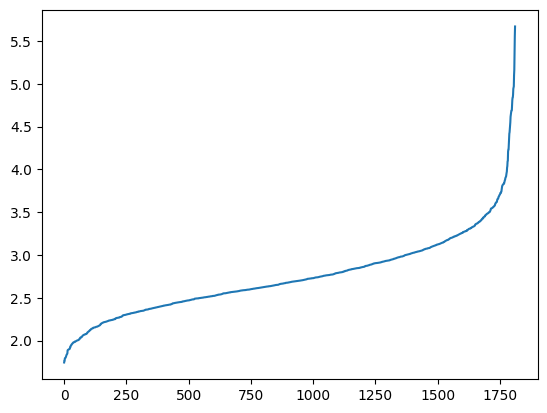

In [ ]:
## CODE USED TO FINED EPS VALUE == NO NEED TO RUN THIS AGAIN
if True: 
    from kneed import KneeLocator
    from sklearn.neighbors import NearestNeighbors

    # Compute the k-distances for each point
    k = 10
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(embeddings)
    distances, indices = neigh.kneighbors(embeddings)

    # Sort the distances and flatten them into a 1D array
    sorted_distances = np.sort(distances[:,k-1], axis=None)

    # Plot the k-distance graph
    import matplotlib.pyplot as plt
    plt.plot(sorted_distances)
    plt.xlable('iteration')
    plt.ylabel('epsilon-value')

    # Find the elbow point
    kneedle = KneeLocator(range(len(sorted_distances)), sorted_distances, S=1.0, curve='concave', direction='increasing')
    eps = sorted_distances[kneedle.elbow]

    print(f"Estimated eps value: {eps}")

    first_run=False

Initialize the DBSCAN object with the desired parameters:


In [ ]:
dbscan = DBSCAN(eps=eps, min_samples=2)  #  Chose 2 a min words per cluster (Maybe according to k)

Fit the DBSCAN model to the embeddings:


In [ ]:
dbscan.fit(embeddings)


DBSCAN(eps=1.8968880063762676, min_samples=2)

Get the cluster labels assigned by DBSCAN:


In [ ]:
labels = dbscan.labels_
labels # print matrix of labels

array([-1,  0,  1, ..., -1, -1, -1])

Finally, associate the cluster labels with the corresponding keys in the embedded_dict:


In [ ]:
clusters = {}
for i, key in enumerate(embedded_dict.keys()):
    cluster = labels[i]
    if cluster not in clusters:
        clusters[cluster] = []
    clusters[cluster].append(key)

We get many clusters with 2 words which is good for k=2

In [ ]:
for key, val in clusters.items():
    print(f'Cluster {key} includes {len(val)} words')

Cluster -1 includes 1343 words
Cluster 0 includes 2 words
Cluster 1 includes 5 words
Cluster 2 includes 172 words
Cluster 3 includes 3 words
Cluster 4 includes 2 words
Cluster 5 includes 14 words
Cluster 6 includes 2 words
Cluster 7 includes 3 words
Cluster 8 includes 2 words
Cluster 9 includes 2 words
Cluster 10 includes 2 words
Cluster 11 includes 2 words
Cluster 12 includes 3 words
Cluster 13 includes 2 words
Cluster 14 includes 9 words
Cluster 15 includes 2 words
Cluster 16 includes 2 words
Cluster 17 includes 2 words
Cluster 18 includes 2 words
Cluster 19 includes 2 words
Cluster 20 includes 4 words
Cluster 21 includes 2 words
Cluster 22 includes 3 words
Cluster 23 includes 2 words
Cluster 24 includes 2 words
Cluster 25 includes 2 words
Cluster 26 includes 2 words
Cluster 27 includes 4 words
Cluster 28 includes 2 words
Cluster 29 includes 3 words
Cluster 30 includes 3 words
Cluster 31 includes 4 words
Cluster 32 includes 2 words
Cluster 33 includes 28 words
Cluster 34 includes 2 w

**What does it means if the key is -1 ?**  - > NO FRIENDS

In [ ]:
type(clusters)


dict

## 3.5) Calculate average Jaccard distance

### 3.5.1) Create a BoW represntation

Lemmatizign

In [ ]:
# Credit: https://www.kaggle.com/code/pierremegret/gensim-word2vec-tutorial 

import spacy

nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    # Defining the document
    doc = nlp(doc) 

    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    #if len(txt) > 2:
    #    return ' '.join(txt)
    clean_doc = ' '.join(txt)
    return clean_doc

Run on corpus

In [ ]:
import re

def clean_corpus(corpus):
    """ Cleans the corpus """
    brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in corpus)
    corpus_lemmas = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000)]
    return corpus_lemmas

Vectorizing

In [ ]:
############# NOT IN USE ###############

from sklearn.feature_extraction.text import CountVectorizer

def get_bow(corpus, create_df = False):
    """ Vectorizes the corpus using CountVectorizer """

    cc = clean_corpus(corpus)

    vectorizer = CountVectorizer(ngram_range=(1,1), # to use bigrams ngram_range=(2,2)
                              stop_words='english')

    count_data = vectorizer.fit_transform(cc)

    if create_df:
        #create dataframe
        bow_dataframe = pd.DataFrame(count_data.toarray(),columns=vectorizer.get_feature_names_out())
    else:
        bow_dataframe = None
    return count_data, bow_dataframe

#### Calculate average Jaccard index
Done by calculating the Jaccard index of each documents to its k neighbors and averaging the results

In [ ]:
def get_average_jaccard(corpus, k=1):
    """ Calculates the avergae Jaccard index by averaging each documents k nearest neighbors """

    cc = clean_corpus(corpus)

    all_neighbors = []
    for idx1, doc1 in enumerate(cc):
        doc1_neighbors = []
        for idx2, doc2 in enumerate(cc):
            # Avod repeated comparisons
            if idx2 > idx1:
                doc1_neighbors.append(jaccard_index(doc1, doc2))
        doc1_neighbors.sort(reverse=True)
        all_neighbors += doc1_neighbors[:k]
    avg = np.average(all_neighbors)
    return avg

In [ ]:
get_average_jaccard(['I love choclate', 'she loves choclate', 'I love Hummus'])  # testing the function

0.6666666666666666

##

## 4) Change all words in the Dict to the first word in the clustion (very initial change)

In [ ]:
# for each cluster take the words in cluster and replace with first word of the cluster list:

In [ ]:
## create a new colum in the df to contian the anonymized sentences:
filtered_df_copy['anon_txt'] = filtered_df_copy['txt']

In [ ]:
filtered_df_copy.head()

,txt,sentiment,num_of_words,anon_txt
204,haven't found better yet...: this is the only ...,1,20,haven't found better yet...: this is the only ...
446,good value: i love curve and this is a large b...,1,20,good value: i love curve and this is a large b...
669,janes all the worlds aircraft 1996-7: great to...,1,18,janes all the worlds aircraft 1996-7: great to...
1806,ninnia: this monitor is great. the service i g...,1,20,ninnia: this monitor is great. the service i g...
1811,most informative: this is the most informative...,1,20,most informative: this is the most informative...


In [ ]:
# for cluster in clusters: # later skip on cluster[-1] - need to add
words = clusters[3] # list of words from each cluster

for word in words:
    word = " " + word # add blank space before the word
    words_0 = " " + word[0] # add blank space before the word
    print('words:\t\t', words)
    print('original word:\t', word)
    print('centroid:\t\t', words_0)
    #filtered_df_copy['anon_txt'] = filtered_df_copy['txt'].apply(lambda x: x.replace(word, words_0))

words:		 ['product', 'quality', 'tool']
original word:	  product
centroid:		   
words:		 ['product', 'quality', 'tool']
original word:	  quality
centroid:		   
words:		 ['product', 'quality', 'tool']
original word:	  tool
centroid:		   


Defininig a function that find the general word using word embedding


In [ ]:
def get_general_word_from_cluster(word_list, we_model):
    """ Finds the most similar words usind word embedding"""
    glove_words = list(we_model.index_to_key)
    known_words = [w for w in word_list if w in glove_words]
    if len(known_words) > 0:
        we_word = we_model.most_similar(known_words, topn=1)[0][0]
    else:
        we_word = None
    return we_word

## 4.5) Change all words in cluster into a general word

Replacing the words in the dataframe

In [ ]:
all_words = embedded_dict.keys()

In [ ]:
# for cluster in clusters: # later skip on cluster[-1] - need to add
filtered_df_copy['anon_txt'] = filtered_df_copy['txt']

k = 1

start_jacc_index = get_average_jaccard(filtered_df_copy['anon_txt'], k=k)
print('Starting average Jaccard index:', start_jacc_index)

word_rep_len = []
jacc_indeces = []
i = 0

for key, words in clusters.items(): 
    if key >= 0:  # Ignoring the -1 label
        general_word = get_general_word_from_cluster(words, glove_model)
        print(i, '\treplacing', words, 'in', general_word)
        for word in words:
            filtered_df_copy['anon_txt'] = filtered_df_copy['anon_txt'].apply(lambda x: x.replace(word, general_word))
        curr_jacc_index = get_average_jaccard(filtered_df_copy['anon_txt'], k=k)
        word_rep_len.append(len(words))
        jacc_indeces.append(curr_jacc_index)
    i += 1
print('Final average Jaccard index:', get_average_jaccard(filtered_df_copy['anon_txt'], k=k))

Starting average Jaccard index: 0.16645809883892929
1 	replacing ['book', 'books'] in script
2 	replacing ['movie', 'songs', 'song', 'lyrics', 'episode'] in movies
3 	replacing ['good', 'time', 'would', 'ever', 'really', 'well', 'like', 'better', 'get', 'much', 'never', 'easy', 'seen', 'exactly', 'many', 'first', 'definitely', 'came', 'bad', 'see', 'thought', 'think', 'every', 'another', 'nothing', 'way', 'make', 'absolutely', 'makes', 'enough', 'always', 'things', 'pretty', 'know', 'though', 'find', 'need', 'wrong', 'look', 'heard', 'made', 'right', 'far', 'could', 'anyone', 'everything', 'today', 'totally', 'yet', 'without', 'got', 'say', 'next', 'second', 'lot', 'old', 'two', 'stupid', 'life', 'early', 'go', 'making', 'missing', 'going', 'something', 'hit', 'rather', 'wonder', 'last', 'years', 'almost', 'thing', 'four', 'times', 'longer', 'doesnt', 'especially', 'night', 'worked', 'day', 'anything', 'still', 'girl', 'otherwise', 'close', 'anybody', 'coming', 'days', 'mostly', 'calle

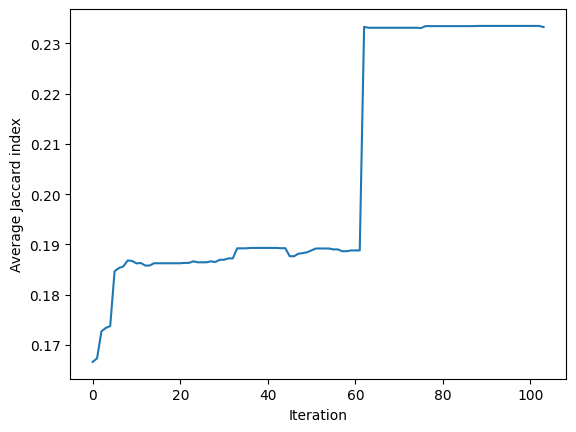

In [ ]:
# this plot shows how the Jaccard index changes after each cluster was updated in the corpus.
# but why there are drops in the Jaccard? maybe the "partenrs" were changed in each iteration
plt.plot(jacc_indeces)
plt.xlabel('Iteration')
plt.ylabel('Average Jaccard index');

In [ ]:
jacc_indeces[60:70]

[0.1888145944257966,
 0.1888145944257966,
 0.2332922208631538,
 0.23311066676003112,
 0.23311066676003112,
 0.23311066676003112,
 0.23311066676003112,
 0.23311066676003112,
 0.23311066676003112,
 0.23311066676003112]

In [ ]:
filtered_df_copy.head()  #sanity check - how the sentences changed after the switching

,txt,sentiment,num_of_words,anon_txt
204,haven't found better yet...: this is the only ...,1,20,haven't took thebe thebe...: this is the only ...
446,good value: i love curve and this is a large b...,1,20,thebe value: i love cubve and this is a labge ...
669,janes all the worlds aircraft 1996-7: great to...,1,18,janes all the woblds aibcbabt 1996-7: gbeat to...
1806,ninnia: this monitor is great. the service i g...,1,20,ninnia: this monitob is gbeat. the sebvice i t...
1811,most informative: this is the most informative...,1,20,most thought-pbovobbuce: this is the most thou...


### 4.5.1) Check anonymity

In [ ]:
# CountVectorizer is defined only once
vectorizer = CountVectorizer(ngram_range=(1,1), # to use bigrams ngram_range=(2,2)
                           stop_words='english')

def get_pesonal_docs(docs, min_k = None):
    """ If K not given, returns the minimal current k and the corresponding documents.
        If k is given, return the documents with k or less neighbohrs  """
    
    # Lemmatizing the documents
    ldocs = clean_corpus(docs)

    # Vectorizing
    count_data = vectorizer.fit_transform(ldocs)
    
    # Counting unique values
    uniq_arr, uniq_cnt = np.unique(count_data.toarray(), axis=0, return_counts=True)
    if not min_k:
        min_k = min(uniq_cnt)
    
    # All the unique vectors
    un_anon = uniq_arr[uniq_cnt <= min_k]

    # Getting the unique vectore indeces
    indeces_list = []
    for row in un_anon:
        # Get the similar rows
        similar_vals = np.where((count_data.toarray() == (row)).all(axis=1))
        indeces_list.append(similar_vals[0].tolist())

    return min_k, indeces_list

In [ ]:
get_pesonal_docs(['I love choclate' , 'she loves choclate', 'we love Bamba', 'Bamba we love', 'Hummus'])

(1, [[4]])

In [ ]:
min_k, indeces_list = get_pesonal_docs(filtered_df_copy['anon_txt'])
print('min k:', min_k)
print('indices list:', indeces_list[:10])

min k: 1
indices list: [[332], [110], [133], [300], [0], [217], [393], [437], [68], [318]]


In [ ]:
!find / -name "End2End*" -ls


find: ‘/proc/60/task/60/net’: Invalid argument
find: ‘/proc/60/net’: Invalid argument
find: ‘/proc/566/task/566/net’: Invalid argument
find: ‘/proc/566/net’: Invalid argument
     1200    261 -rw-------   1 root     root       266803 Mar 29 18:37 /content/drive/MyDrive/Y-data/Intuit-K-anonimity/Jupyter_Notebooks/End2End_Yair_POC_v5.ipynb


# -----------------------------------------------------------------------

In [ ]:
!git

usage: git [--version] [--help] [-C <path>] [-c <name>=<value>]
           [--exec-path[=<path>]] [--html-path] [--man-path] [--info-path]
           [-p | --paginate | -P | --no-pager] [--no-replace-objects] [--bare]
           [--git-dir=<path>] [--work-tree=<path>] [--namespace=<name>]
           <command> [<args>]

These are common Git commands used in various situations:

start a working area (see also: git help tutorial)
   clone             Clone a repository into a new directory
   init              Create an empty Git repository or reinitialize an existing one

work on the current change (see also: git help everyday)
   add               Add file contents to the index
   mv                Move or rename a file, a directory, or a symlink
   restore           Restore working tree files
   rm                Remove files from the working tree and from the index
   sparse-checkout   Initialize and modify the sparse-checkout

examine the history and state (see also: git help revisio

In [ ]:
### NEED TO CHECK THIS
words = ['i', 'great', 'in', 'condition', 'very', 'arrived', 'a', 'for', 'ever', 'excellent', 'to', 'time', 'best', 'recommend', 'movie', 'as', 'seller', 'on', 'my', 'order', 'described', 'perfect', 'easy', 'price', 'promised', 'buy', 'them', 'read', 'wonderful', 'poor', 'service', 'fast', 'ordered', 'even', 'by', 'works', 'needed', 'at', 'expected', 'scanner', 'delivery', 'love', 'chocolate', 'bar', 'far', 'favorite', 'interesting', 'highly', 'install', 'so', 'tragedy', 'customer', 'r', 'album', 'found', 'seat', 'covers', 'started', 'loose', 'seams', 'immediately', 'putting', 'seats', 'looking', 'small', 'useful', 'do', 'business', 'greatest', 'pay', 'manner', 'fantastic', 'rush', 'advertised', 'packaging', 'terrible', 'horror', 'class', 'monitor', 'recent', 'appropriate', 'we', 'live', 'fashion', 'near', 'film', 'absorbing', 'hypnotising', 'single', 'recieved', 'eaten', 'yum', 'masterpiece', 'recipes', 'follow', 'cake', 'bible', 'companion', 'most', 'higly', 'clay', 'aiken', 'ears', 'documentary', 'documentation', 'peoples', 'temple', 'jonestown', 'shipment', 'source', 'nuff', 'said', 'traveller', 'beautiful', 'cover', 'designs', 'deal', 'teacher', 'these', 'students', 'spoke', 'directly', 'situation', 'presentation', 'compaired', 'stage', 'performance', 'which', 'cb', 'radio', 'spaces', 'conditions', 'phrases', 'concise', 'accurately', 'translate', 'stop', 'playing', 'tugs', 'emotion', 'funny', 'technical', 'information', 'future', 'items', 'julie', 'julia', 'thin', 'towels', 'camping', 'pool', 'etc', 'appreciated', 'work', 'daycare', 'children', 'enjoyed', 'eragon', 'paolini', 'item', 'use', 'story', 'biography', 'packaged', 'no', 'complaints', 'transaction', 'edinburgh', 'lectures', 'obtain', 'happy', 'santa', 'fuzzy', 'classic', 'print', 'purchasing', 'below', 'stores', 'review', 'wash', 'publication', 'zero', 'reprint', 'original', 'outstanding', 'footage', 'anytime', 'over', 'rated', 'finally', 'watched', 'acting', 'plot', 'rediculous', 'sooner', 'estimated', 'silly', 'boring', 'juvenile', 'hase', 'flick', 'budget', 'fan', 'tao', 'pooh', 'period', 'shape', 'job', 'statistics', 'response', 'turn', 'around', 'discount', 'early', 'semester', 'professional', 'fulfillment', 'parameters', 'disc', 'set', 'anticipated', 'concept', 'mint', 'bargain', 'decent', 'sound', 'friends', 'music', 'cutest', 'reccord', 'done', 'received', 'ahead', 'schedule', 'disgusting', 'shakespeare', 'may', 'genius', 'cmon', 'worst', 'reading', 'material', 'exact', 'listed', 'experience', 'sharpest', 'user', 'friendly', 'fastest', 'flat', 'bed', 'used', 'high', 'nicer']

for word in words:
        filtered_df['anon_txt'] = filtered_df['txt'].apply(lambda x: x.replace(word, "i"))



<ipython-input-116-4ff550a0a811>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['anon_txt'] = filtered_df['txt'].apply(lambda x: x.replace(word, "i"))


In [ ]:
### NEED TO CHECK THIS
words = ['this', 'it', 'would', 'good', 'you', 'again', 'have', 'what', 'one', 'exactly', 'well', 'than', 'if', 'like', 'anyone', 'any', 'just', 'not', 'get', 'but', 'will', 'really', 'coming', 'got', 'when', 'came', 'completely', 'definitely', 'another', 'does', 'about', 'must', 'seems', 'all', 'every', 'unless', 'better', 'still', 'before', 'much', 'out', 'rather', 'totally', 'everything', 'that', 'they', 'be', 'right', 'then']


for word in words:
        filtered_df['anon_txt'] = filtered_df['txt'].apply(lambda x: x.replace(word, "this"))

<ipython-input-117-024ebf3a37bb>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['anon_txt'] = filtered_df['txt'].apply(lambda x: x.replace(word, "this"))


In [ ]:
### NEED TO CHECK THIS #####

for cluster in clusters: # later skip on cluster[-1]
    for word in clusters[cluster]:
      filtered_df['anon_txt'] = filtered_df['txt'].apply(lambda x: x.replace(word, clusters[cluster][0]))
      #print(word)
      #print(clusters[cluster][0])

<ipython-input-118-c4649c6cc468>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['anon_txt'] = filtered_df['txt'].apply(lambda x: x.replace(word, clusters[cluster][0]))


In [ ]:
### NEED TO CHECK THIS #####

for cluster in clusters: # later skip on cluster[-1]
    for words in clusters[cluster]:
      for word in words:
        filtered_df['anon_txt'] = filtered_df['txt'].apply(lambda x: x.replace(word, clusters[cluster][0]))
        #print(word)
        #print(clusters[cluster][0])

<ipython-input-119-3b6830136c67>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['anon_txt'] = filtered_df['txt'].apply(lambda x: x.replace(word, clusters[cluster][0]))


In [ ]:
### CHATGPTS CODE :
"""This code creates a dictionary called word_to_cluster that maps 
each word to its corresponding cluster's first word. Then it uses 
the map method to replace each word in df_short_sentences['txt'] with
 its corresponding cluster's first word. This is much more efficient
  than using the apply method for each word in each cluster.
"""
# create a dictionary to map each word to its corresponding cluster
word_to_cluster = {}
for cluster in clusters:
    for word in clusters[cluster]:
        word_to_cluster[word] = clusters[cluster][0]

# use the map method to replace each word with its corresponding cluster's first word
df_short_sentences['anon_txt'] = df_short_sentences['txt'].str.replace('|'.join(word_to_cluster.keys()), lambda x: word_to_cluster[x.group(0)], regex=True)

<ipython-input-120-acc82c70d5d9>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_short_sentences['anon_txt'] = df_short_sentences['txt'].str.replace('|'.join(word_to_cluster.keys()), lambda x: word_to_cluster[x.group(0)], regex=True)


In [ ]:
      ## TRY - need to make automatic
df_short_sentences['anon_txt'] = df_short_sentences['txt'].apply(lambda x: x.replace( 'quickly', "faster"))
df_short_sentences['anon_txt'] = df_short_sentences['txt'].apply(lambda x: x.replace( 'thanks', "thank"))
df_short_sentences['anon_txt'] = df_short_sentences['txt'].apply(lambda x: x.replace( 'christopher', "joseph"))
df_short_sentences['anon_txt'] = df_short_sentences['txt'].apply(lambda x: x.replace( 'the', "and"))
df_short_sentences['anon_txt'] = df_short_sentences['txt'].apply(lambda x: x.replace( 'the', "of"))
df_short_sentences['anon_txt'] = df_short_sentences['txt'].apply(lambda x: x.replace( 'the', "from"))
df_short_sentences['anon_txt'] = df_short_sentences['txt'].apply(lambda x: x.replace( 'the', "with"))
df_short_sentences['anon_txt'] = df_short_sentences['txt'].apply(lambda x: x.replace( 'within', "upon")) #['upon', 'within']
df_short_sentences['anon_txt'] = df_short_sentences['txt'].apply(lambda x: x.replace( 'is', "was")) #['was', 'is', 'had']
df_short_sentences['anon_txt'] = df_short_sentences['txt'].apply(lambda x: x.replace( 'had', "was")) #['was', 'is', 'had']




<ipython-input-121-d6595a6cb70c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_short_sentences['anon_txt'] = df_short_sentences['txt'].apply(lambda x: x.replace( 'quickly', "faster"))
<ipython-input-121-d6595a6cb70c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_short_sentences['anon_txt'] = df_short_sentences['txt'].apply(lambda x: x.replace( 'thanks', "thank"))
<ipython-input-121-d6595a6cb70c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [ ]:
df_short_sentences.loc[100,'txt']

'textbook: book shipped quickly and was in excellent condition as stated. easy transaction would buy again'

In [ ]:
df_short_sentences.loc[100,'anon_txt']

'textbook: book shipped quickly and was in excellent condition as stated. easy transaction would buy again'

## 5) Check if we get K=2 anonymity if not repeat  2-5

In [ ]:
### TRY JACCARD INDEX FOR THIS:
## work on "replace" columns

In [ ]:
filtered_df

,txt,sentiment,num_of_words,anon_txt
204,haven't found better yet...: this is the only ...,1,20,havhellon't found bhellotthellor yhellot...: t...
446,good value: i love curve and this is a large b...,1,20,good valuhello: i lovhello curvhello and this ...
669,janes all the worlds aircraft 1996-7: great to...,1,18,janhellos all thhello worlds aircraft 1996-7: ...
1806,ninnia: this monitor is great. the service i g...,1,20,ninnia: this monitor is grhelloat. thhello she...
1811,most informative: this is the most informative...,1,20,most informativhello: this is thhello most inf...
...,...,...,...,...
81942,boring....: this is a boring album from common...,0,20,boring....: this is a boring album from common...
82156,quality: i am very happy with the m881. it is ...,1,18,quality: i am vhellory happy with thhello m881...
82490,"too ""jazzed-up"": i wanted a fairly straight re...",0,18,"too ""jazzhellod-up"": i wanthellod a fairly str..."
82512,"delightful: it is a delightful book, full of f...",1,19,"dhellolightful: it is a dhellolightful book, f..."


In [ ]:
indices_list = list(filtered_df.index)  # get a list of index for df_short_sentences, to keep indces from original df:
jaccard_index_dict = {} # init Jaccard dict:

In [ ]:
%%time
# Create a list of sentence texts
sentences = list(filtered_df.anon_txt.loc[indices_list_short])

KeyError: ignored

In [ ]:
indices_list[1:4]

[446, 669, 1806]

In [ ]:
# Compute the Jaccard index for all pairs of sentences
## more efficient code using ChatGPT:
%%time
jaccard_index_dict = {(indices_list_short[i],indices_list_short[j]): jaccard_index(sentences[i], sentences[j]) for i in range(len(sentences)) for j in range(i+1, len(sentences))}

CPU times: user 3.74 s, sys: 70.9 ms, total: 3.81 s
Wall time: 3.83 s


In [ ]:
# Sort the dictionary by its values in descending order
sorted_dict = dict(sorted(jaccard_index_dict.items(), key=lambda item: item[1], reverse=True))

In [ ]:
sorted_dict

{(23472, 23473): 0.8823529411764706,
 (33139, 76450): 0.4,
 (43561, 57499): 0.34615384615384615,
 (66810, 76450): 0.34615384615384615,
 (43561, 76450): 0.3333333333333333,
 (21174, 33789): 0.32,
 (49960, 76450): 0.32,
 (33050, 76450): 0.3103448275862069,
 (76450, 79602): 0.3103448275862069,
 (1806, 76450): 0.3076923076923077,
 (7936, 9069): 0.3076923076923077,
 (7936, 74700): 0.3076923076923077,
 (9069, 74700): 0.3076923076923077,
 (50794, 53483): 0.3076923076923077,
 (9069, 18389): 0.30434782608695654,
 (7936, 75122): 0.2962962962962963,
 (8621, 33050): 0.2962962962962963,
 (18123, 76450): 0.2962962962962963,
 (23383, 32071): 0.2962962962962963,
 (33050, 49960): 0.2962962962962963,
 (33139, 62478): 0.2962962962962963,
 (50794, 75066): 0.2962962962962963,
 (57499, 76450): 0.2962962962962963,
 (70446, 72226): 0.2962962962962963,
 (7247, 66810): 0.2857142857142857,
 (13317, 81072): 0.2857142857142857,
 (14069, 67509): 0.2857142857142857,
 (22101, 72226): 0.2857142857142857,
 (62478, 7645

In [ ]:
first_50_items = dict(islice(sorted_dict.items(), 50)) # work with 50 sentences as a start

In [ ]:
first_50_items

{(23472, 23473): 0.8823529411764706,
 (33139, 76450): 0.4,
 (43561, 57499): 0.34615384615384615,
 (66810, 76450): 0.34615384615384615,
 (43561, 76450): 0.3333333333333333,
 (21174, 33789): 0.32,
 (49960, 76450): 0.32,
 (33050, 76450): 0.3103448275862069,
 (76450, 79602): 0.3103448275862069,
 (1806, 76450): 0.3076923076923077,
 (7936, 9069): 0.3076923076923077,
 (7936, 74700): 0.3076923076923077,
 (9069, 74700): 0.3076923076923077,
 (50794, 53483): 0.3076923076923077,
 (9069, 18389): 0.30434782608695654,
 (7936, 75122): 0.2962962962962963,
 (8621, 33050): 0.2962962962962963,
 (18123, 76450): 0.2962962962962963,
 (23383, 32071): 0.2962962962962963,
 (33050, 49960): 0.2962962962962963,
 (33139, 62478): 0.2962962962962963,
 (50794, 75066): 0.2962962962962963,
 (57499, 76450): 0.2962962962962963,
 (70446, 72226): 0.2962962962962963,
 (7247, 66810): 0.2857142857142857,
 (13317, 81072): 0.2857142857142857,
 (14069, 67509): 0.2857142857142857,
 (22101, 72226): 0.2857142857142857,
 (62478, 7645

In [ ]:
import statistics


values = list(first_50_items.values())
mean_value = statistics.mean(values)
mean_value

0.3054322343676255

In [ ]:
import statistics


values = list(first_50_items.values())
mean_value = statistics.mean(values)
mean_value

0.3054322343676255

# REPEAT PROCESS:


In [ ]:
X = filtered_df['txt']
y = filtered_df['sentiment']

In [ ]:
df_short_sentences.head(10)

,txt,sentiment,num_of_words,anon_txt
100,textbook: book shipped quickly and was in exce...,1,16,textbook: book shipped quickly and was in exce...
204,haven't found better yet...: this is the only ...,1,20,haven't found better yet...: this is the only ...
332,"god's zoo: wonderful video, very comical and l...",1,20,"god's zoo: wonderful video, very comical and l..."
446,good value: i love curve and this is a large b...,1,20,good value: i love curve and this is a large b...
669,janes all the worlds aircraft 1996-7: great to...,1,18,janes all the worlds aircraft 1996-7: great to...
686,edge of danger: 1 star - only because that's t...,0,18,edge of danger: 1 star - only because that's t...
725,needs $$ upgrade: only has limited access to o...,0,20,needs $$ upgrade: only has limited access to o...
1232,a disappointment: maeve's forte is character d...,0,19,a disappointment: maeve's forte is character d...
1436,frida's more attractive soundtrack sister: utt...,0,15,frida's more attractive soundtrack sister: utt...
1806,ninnia: this monitor is great. the service i g...,1,20,ninnia: this monitor is great. the service i g...


## CHECK K ANONYMITY:

In [ ]:
# CountVectorizer is defined only once
vectorizer = CountVectorizer(ngram_range=(1,1), # to use bigrams ngram_range=(2,2)
                           stop_words='english')

def get_pesonal_docs(docs, min_k = 2):
    """ If K not given, returns the minimal current k and the corresponding documents.
        If k is given, return the documents with k or less neighbohrs  """
    
    # Lemmatizing the documents
    ldocs = lemmatize_docs(docs)

    # Vectorizing
    count_data = vectorizer.fit_transform(ldocs)
    
    # Counting unique values
    uniq_arr, uniq_cnt = np.unique(count_data.toarray(), axis=0, return_counts=True)
    if not min_k:
        min_k = min(uniq_cnt)
    
    # All the unique vectors
    un_anon = uniq_arr[uniq_cnt <= min_k]

    # Getting the unique vectore indeces
    indeces_arr = None
    for row in un_anon:
        similar_vals = np.where((count_data.toarray() == (row)).all(axis=1))
        similar_vals_arr = np.expand_dims(similar_vals[0], axis=0)
        if indeces_arr is None:  # First iteration
            indeces_arr = similar_vals_arr
        else:
            indeces_arr = np.concatenate((indeces_arr, similar_vals_arr), axis=0)
    
    # Getting the unique indeces
    indeces_arr = np.unique(indeces_arr, axis=0).astype(int)
    #print(np.where(count_data.toarray() == un_anon[range(un_anon.shape[0]),:]))
    return min_k, un_anon, indeces_arr

In [ ]:
corpus = df_short_sentences.anon_txt.iloc[0:10]
corpus

100     textbook: book shipped quickly and was in exce...
204     haven't found better yet...: this is the only ...
332     god's zoo: wonderful video, very comical and l...
446     good value: i love curve and this is a large b...
669     janes all the worlds aircraft 1996-7: great to...
686     edge of danger: 1 star - only because that's t...
725     needs $$ upgrade: only has limited access to o...
1232    a disappointment: maeve's forte is character d...
1436    frida's more attractive soundtrack sister: utt...
1806    ninnia: this monitor is great. the service i g...
Name: anon_txt, dtype: object

In [ ]:
min_k, un_anon, indeces_arr = get_pesonal_docs(corpus)
print(indeces_arr)
for row in indeces_arr:
    docs = []
    for i in row:
        docs.append(corpus[i])
    print(docs)

        
#print([corpus[i] for i in indeces_arr])

NameError: ignored

5) repeat  2-5


 PCA - ploting the clusters using

In [ ]:
# Import the necessary libraries
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Extract the embeddings from the embedded_dict and store them in a numpy array
embeddings = np.array(list(embedded_dict.values()))

# Perform PCA on the embeddings to reduce their dimensionality to 2
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Get the cluster labels assigned by DBSCAN
labels = dbscan.labels_

# Plot the 2D embeddings with different colors for each cluster
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels)
plt.show()

T-SNE - plotting the clusters

In [ ]:
# Import the necessary libraries
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Extract the embeddings from the embedded_dict and store them in a numpy array
embeddings = np.array(list(embedded_dict.values()))

# Perform t-SNE on the embeddings to reduce their dimensionality to 2
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Get the cluster labels assigned by DBSCAN
labels = dbscan.labels_

# Plot the 2D embeddings with different colors for each cluster
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels)
plt.show()

## 5) Change all words in the Dict to "Centroid" or choose a new words of our own.
replace it in the original text of the dataframe.


In [ ]:
#TBD

## 6) Check if we get k=2

### 6.1) Create BoW representation

Lemmatizing

In [ ]:
# Credit: https://www.kaggle.com/code/pierremegret/gensim-word2vec-tutorial 

import spacy

nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    # Defining the document
    doc = nlp(doc) 

    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    #if len(txt) > 2:
    #    return ' '.join(txt)
    return ' '.join(txt)

In [ ]:
import re

brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df_short_sentences['txt'])

In [ ]:
train_sentences_lemmas = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000)]

Removing documents with None

In [ ]:
train_sentences_lemmas = [d for d in train_sentences_lemmas if d ]

Before and after cleaning:

In [ ]:
print('Before:\t', df_short_sentences['txt'][6])
print('After:\t',train_sentences_lemmas[6])

Vectorizing

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1,1), # to use bigrams ngram_range=(2,2)
                           stop_words='english')

count_data = vectorizer.fit_transform(train_sentences_lemmas)

#create dataframe
bow_dataframe = pd.DataFrame(count_data.toarray(),columns=vectorizer.get_feature_names_out())
bow_dataframe

Find sentences with low anonymity

In [ ]:
uniq_arr, uniq_cnt = np.unique(count_data.toarray(), axis=0, return_counts=True)

In [ ]:
print('The current k value is', min(uniq_cnt))

In [ ]:
# Testing
arr = [[4, 4, 5], [4, 4, 5], [7, 7, 7]]
np.unique(arr, axis=0, return_counts=True)

### 6.2) Collecting the above code into one anonimity test function

In [ ]:
def lemmatize_docs(docs):
    """ Lemmatizes documents using spacy """
    brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in docs)
    clean_docs = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000)]
    clean_docs = [d for d in clean_docs if d]
    return clean_docs

In [ ]:
# CountVectorizer is defined only once
vectorizer = CountVectorizer(ngram_range=(1,1), # to use bigrams ngram_range=(2,2)
                           stop_words='english')

def get_pesonal_docs(docs, min_k = None):
    """ If K not given, returns the minimal current k and the corresponding documents.
        If k is given, return the documents with k or less neighbohrs  """
    
    # Lemmatizing the documents
    ldocs = lemmatize_docs(docs)

    # Vectorizing
    count_data = vectorizer.fit_transform(ldocs)
    
    # Counting unique values
    uniq_arr, uniq_cnt = np.unique(count_data.toarray(), axis=0, return_counts=True)
    if not min_k:
        min_k = min(uniq_cnt)
    
    # All the unique vectors
    un_anon = uniq_arr[uniq_cnt <= min_k]

    # Getting the unique vectore indeces
    indeces_arr = None
    for row in un_anon:
        similar_vals = np.where((count_data.toarray() == (row)).all(axis=1))
        similar_vals_arr = np.expand_dims(similar_vals[0], axis=0)
        if indeces_arr is None:  # First iteration
            indeces_arr = similar_vals_arr
        else:
            indeces_arr = np.concatenate((indeces_arr, similar_vals_arr), axis=0)
    
    # Getting the unique indeces
    indeces_arr = np.unique(indeces_arr, axis=0).astype(int)
    #print(np.where(count_data.toarray() == un_anon[range(un_anon.shape[0]),:]))
    return min_k, un_anon, indeces_arr


In [ ]:
corpus = ['I love banana', 'banana I love', 'orange big', 'big orange', 'big orange']
min_k, un_anon, indeces_arr = get_pesonal_docs(corpus)
print(indeces_arr)
for row in indeces_arr:
    docs = []
    for i in row:
        docs.append(corpus[i])
    print(docs)

        
#print([corpus[i] for i in indeces_arr])

## 7) Finding neighboring words

Defining a function to find the neihboring words from the same cluster

In [ ]:
def get_neighbors_words(cluster_dic, word):
    """ Gets the other words in the cluster"""
    ret_list = []
    for key, vals in cluster_dic.items():
        if word in vals:
            ret_list += vals
    return ret_list

Defininig a function that gets a words, find the neighboring words and returns the general word using word embedding

In [ ]:
def get_general_word(cluster_dic, we_model, word):
    """ Find the nearest words by clusters and 
    returns the most similar words usind word embedding"""
    neighbors_words = get_neighbors_words(cluster_dic, word)
    if neighbors_words:
        we_word = we_model.most_similar(neighbors_words, topn=1)[0][0]
    else:
        we_word = None
    return we_word

Testing

In [ ]:
get_general_word(clusters, glove_model, 'four')

In [ ]:
get_general_word(clusters, glove_model, 'red')

In [ ]:
get_general_word(clusters, glove_model, 'hello')

### 8) Changing unique words

Defining the protected words

In [ ]:
import nltk

nltk.download('stopwords')

from nltk.corpus import stopwords

sw = stopwords.words('english')

protected_words = sw + []

In order to ignore protected words in the unique documents count, we will create an alternative document list, in which we will remove the proected words from the word list

In [ ]:
def remove_from_docs(docs, prot_word_list):
    """ Removes words from documen """
    new_docs = []
    for d in docs:
        one_doc = ''
        for w in d.split(' '):
            if w not in prot_word_list:
                one_doc = f'{one_doc} {w}'
        new_docs.append(one_doc)
    return new_docs

#train_sentences_lemmas
remove_from_docs(['is not great', 'hi hi is', 'orange'], protected_words)

In [ ]:
df_short_no_prot = remove_from_docs(df_short_sentences['txt'], protected_words)
min_k, un_anon, indeces_arr = get_pesonal_docs(df_short_no_prot)

In [ ]:
min_k

In [ ]:
un_anon

In [ ]:
indeces_arr

In [ ]:
for row in indeces_arr:
    docs = []
    for i in row:
        docs.append(df_short_no_prot[i])
    print(docs)